# London Housing - Exploratory Data Analysis

Using the following dataset from Kaggle: [Kaggle](https://www.kaggle.com/datasets/oktayrdeki/houses-in-london)
- "10m_london_houses.csv" | 130 kB

This notebook will investigate the data and aim to answer the following questions.

1. What predicts price most strongly? (Likely: Square Meters, Neighborhood, Property Type)
2. What's the data quality? (Missing values, outliers, errors)
3. What transformations are needed? (Log price? Scale features? Encode categories?)
4. Are there data segments? (Luxury vs standard, urban vs suburban)
5. What features to engineer? (Price per sqm, age categories, luxury indicators)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print(np.__version__)

1.24.3


Load data

In [14]:
def calculate_penalty_distance(rounds):
    missed = 0
    for r in rounds:
        missed += (5 - r)
    return 150 * missed

print(calculate_penalty_distance([5, 4, 3, 5, 2]))

900


In [2]:
data_path = 'data/10m_london_houses_.csv'
housing_df = pd.read_csv(data_path)

housing_df.head()

,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


## 1. Price

Plot price distribution

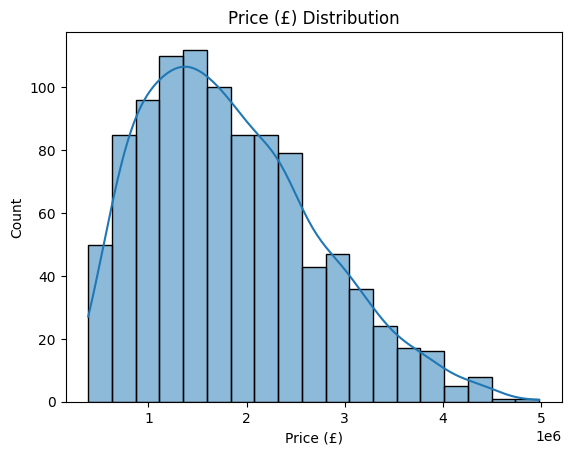

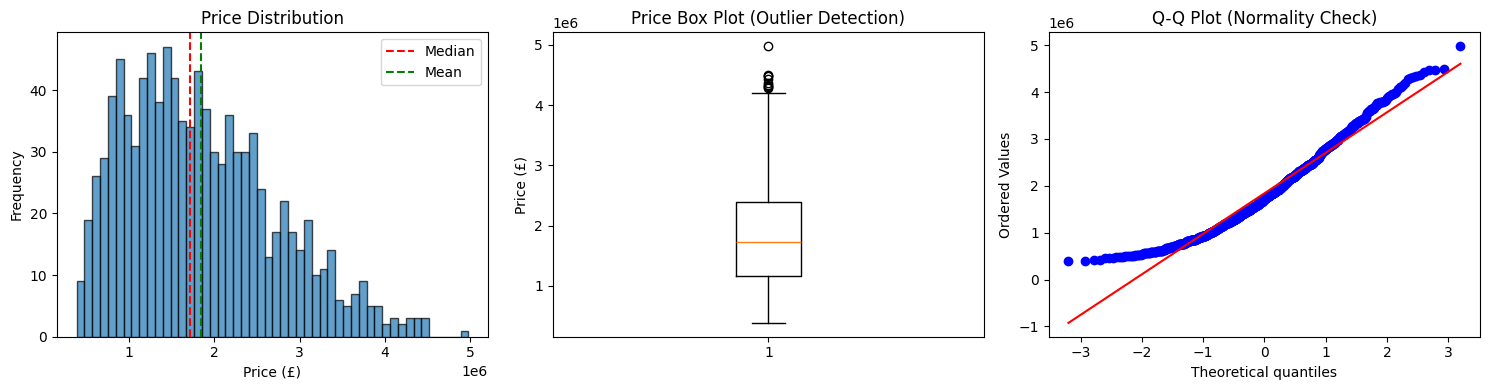

In [5]:
# Price distribution
plt.figure()
sns.histplot(housing_df["Price (£)"], kde=True)
plt.title("Price (£) Distribution")
plt.xlabel("Price (£)")
plt.show()

# Price distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(housing_df['Price (£)'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution')
axes[0].axvline(housing_df['Price (£)'].median(), color='red', linestyle='--', label='Median')
axes[0].axvline(housing_df['Price (£)'].mean(), color='green', linestyle='--', label='Mean')
axes[0].legend()

# Box plot
axes[1].boxplot(housing_df['Price (£)'])
axes[1].set_ylabel('Price (£)')
axes[1].set_title('Price Box Plot (Outlier Detection)')

# Q-Q plot
stats.probplot(housing_df['Price (£)'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')

plt.tight_layout()
# plt.savefig(plotDir + 'price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Detect outliers using IQR method
Q1 = housing_df['Price (£)'].quantile(0.25)
Q3 = housing_df['Price (£)'].quantile(0.75)
IQR = Q3 - Q1
outliers = housing_df[(housing_df['Price (£)'] < Q1 - 1.5 * IQR) | (housing_df['Price (£)'] > Q3 + 1.5 * IQR)]

Plot price per square meter distribution

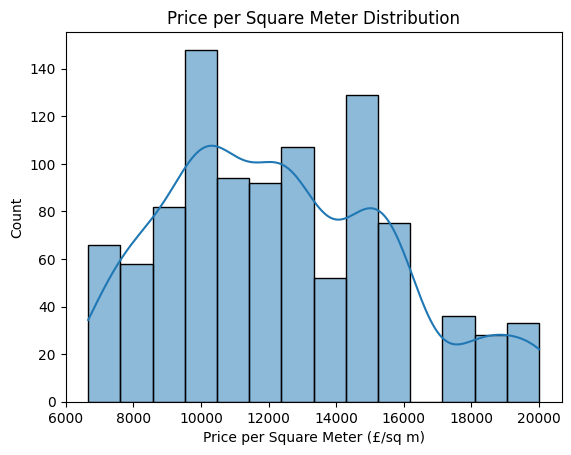

In [6]:
# Create price per square foot column
housing_df['Price per sq m'] = housing_df['Price (£)'] / housing_df['Square Meters']
# Price per square foot distribution
plt.figure()
sns.histplot(housing_df["Price per sq m"], kde=True)
plt.title("Price per Square Meter Distribution")
plt.xlabel("Price per Square Meter (£/sq m)")
plt.show()

## 2. Numerical Data

Extract numerica columns.

In [7]:
numeric_cols = ["Price (£)", "Square Meters", "Bedrooms", "Bathrooms", "Building Age"]

Correlation matrix.

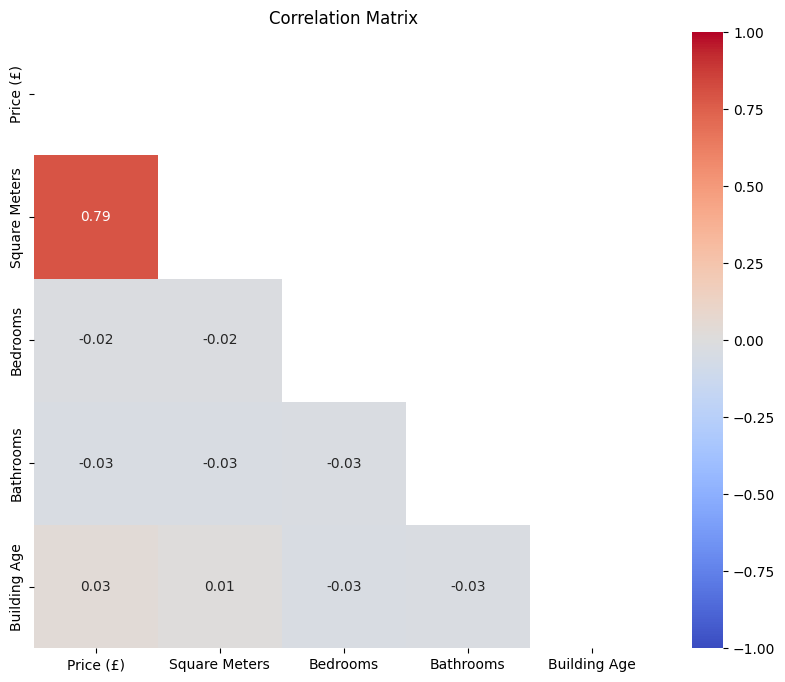

In [8]:
corr_mask = np.triu(np.ones_like(housing_df[numeric_cols].corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(housing_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", mask=corr_mask, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Pairwise plot

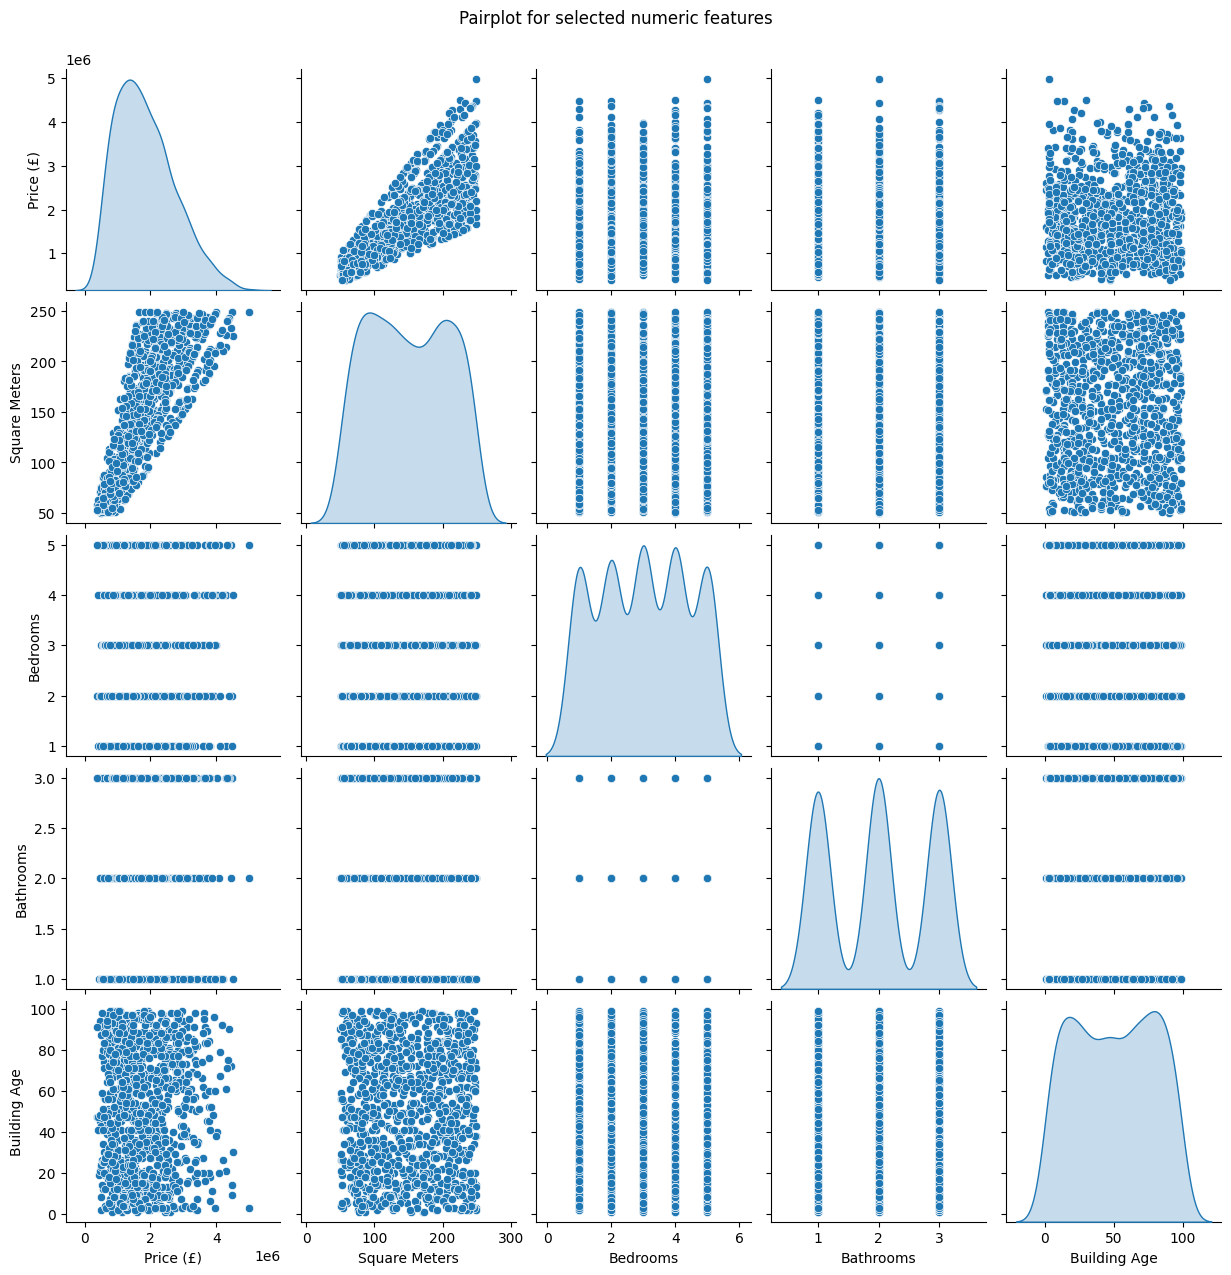

In [6]:
# Pairwise scatter for a few key numeric features (pairplot)
sns.pairplot(housing_df[numeric_cols], diag_kind="kde")
plt.suptitle("Pairplot for selected numeric features", y=1.02)
plt.show()

## 3. Categorical Data

Square meters vs price, colored by neighborhood

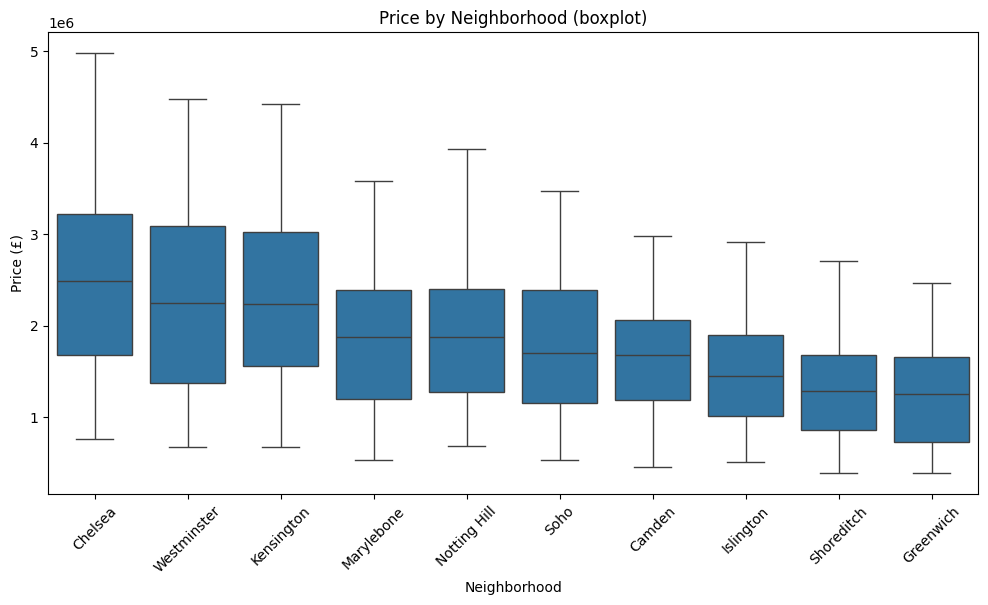

In [10]:
# Boxplot: Price by Neighborhood
plt.figure(figsize=(12,6))
order = housing_df.groupby("Neighborhood")["Price (£)"].median().sort_values(ascending=False).index
sns.boxplot(data=housing_df, x="Neighborhood", y="Price (£)", order=order)
plt.xticks(rotation=45)
plt.title("Price by Neighborhood (boxplot)")
plt.show()

Violin plot?

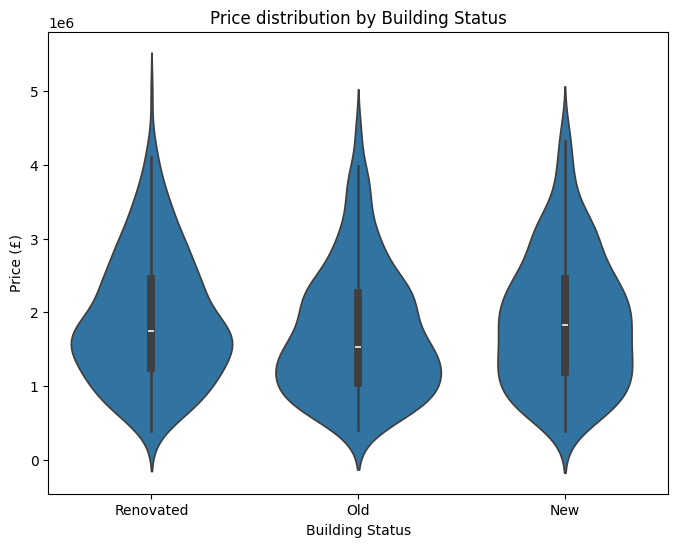

In [13]:
# Violin plot: Price distribution by Building Status
plt.figure(figsize=(8,6))
sns.violinplot(data=housing_df, x="Building Status", y="Price (£)")
plt.title("Price distribution by Building Status")
plt.show()

Look at street addresses

Neighborhood data - why all straight lines?